# Bank Marketing Data

In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import datasets
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
%matplotlib inline
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as PImage
from scipy import stats

In [258]:
# Load data file
bank=pd.read_csv('data/bank/bank-full.csv', sep=';')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [259]:
bank.shape

(45211, 17)

## Summary of data

### Categorical Variables :
**[1] job      :** admin,technician, services, management, retired, blue-collar, unemployed, entrepreneur,
               housemaid, unknown, self-employed, student
<br>**[2] marital  :** married, single, divorced
<br>**[3] education:** secondary, tertiary, primary, unknown
<br>**[4] default  :** yes, no
<br>**[5] housing  :** yes, no
<br>**[6] loan     :** yes, no 
<br>**[7] deposit  :** yes, no ** (Dependent Variable)**
<br>**[8] contact  :** unknown, cellular, telephone
<br>**[9] month    :** jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec
<br>**[10] poutcome:** unknown, other, failure, success

### Numerical Variables:
**[1] age
<br>[2] balance
<br>[3] day
<br>[4] duration
<br>[5] campaign
<br>[6] pdays
<br>[7] previous**

### Treat categorical data

In [260]:
# Make a copy for parsing
bank_data = bank.copy()

####  poutcome 

In [261]:
# Combine 'unknown' and 'other'
bank_data['poutcome'] = bank_data['poutcome'].replace(['unknown'] , 'other')
bank_data.poutcome.value_counts()

other      38799
failure     4901
success     1511
Name: poutcome, dtype: int64

In [262]:
# Drop 'contact', as every participant has been contacted. 
bank_data.drop('contact', axis=1, inplace=True)

####  replace to booleans 

In [263]:
# values for "default" : yes/no
bank_data["default"]
bank_data['credit_default'] = bank_data['default'].map( {'yes':1, 'no':0} )
bank_data.drop('default', axis=1,inplace = True)

# values for "housing" : yes/no
bank_data["housing_loan"]=bank_data['housing'].map({'yes':1, 'no':0})
bank_data.drop('housing', axis=1,inplace = True)

# values for "loan" : yes/no
bank_data["personal_loan"] = bank_data['loan'].map({'yes':1, 'no':0})
bank_data.drop('loan', axis=1, inplace=True)

#### month, day

In [264]:
# Drop 'month' and 'day' as they don't have any intrinsic meaning
bank_data.drop('month', axis=1, inplace=True)
bank_data.drop('day', axis=1, inplace=True)

#### duration

In [265]:
# Drop duration, since it is not known before the call and highly affects the outcome
bank_data.drop('duration', axis=1, inplace=True)

#### y

In [266]:
# values for "y" : yes/no
bank_data["deposit"] = bank_data['y'].map({'yes':1, 'no':0})
bank_data.drop('y', axis=1, inplace=True)

In [267]:
bank_data["deposit"]

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: deposit, Length: 45211, dtype: int64

### Convert categorical data

In [268]:
bank_data.head()

,age,job,marital,education,balance,campaign,pdays,previous,poutcome,credit_default,housing_loan,personal_loan,deposit
0,58,management,married,tertiary,2143,1,-1,0,other,0,1,0,0
1,44,technician,single,secondary,29,1,-1,0,other,0,1,0,0
2,33,entrepreneur,married,secondary,2,1,-1,0,other,0,1,1,0
3,47,blue-collar,married,unknown,1506,1,-1,0,other,0,1,0,0
4,33,unknown,single,unknown,1,1,-1,0,other,0,0,0,0


In [269]:
# Use pandas dummy to convert categorical data
bank_with_dummies = pd.get_dummies(data=bank_data, columns = ['job', 'marital', 'education', 'poutcome'], prefix = ['job', 'marital', 'education', 'poutcome'])
bank_with_dummies.head()

,age,balance,campaign,pdays,previous,credit_default,housing_loan,personal_loan,deposit,job_admin.,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success
0,58,2143,1,-1,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
1,44,29,1,-1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
2,33,2,1,-1,0,0,1,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,47,1506,1,-1,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,1,0
4,33,1,1,-1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0


In [379]:
bank_with_dummies.describe()

,age,balance,campaign,pdays,previous,credit_default,housing_loan,personal_loan,deposit,job_admin.,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,...,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,2.763841,40.197828,0.580323,0.018027,0.555838,0.160226,0.116985,0.114375,...,0.115171,0.601933,0.282896,0.151534,0.513194,0.294198,0.041074,0.108403,0.858176,0.033421
std,10.618762,3044.765829,3.098021,100.128746,2.303441,0.133049,0.496878,0.366820,0.321406,0.318269,...,0.319232,0.489505,0.450411,0.358572,0.499831,0.455687,0.198464,0.310892,0.348873,0.179735
min,18.000000,-8019.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,72.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,39.000000,448.000000,2.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,48.000000,1428.000000,3.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,95.000000,102127.000000,63.000000,871.000000,275.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Analysis

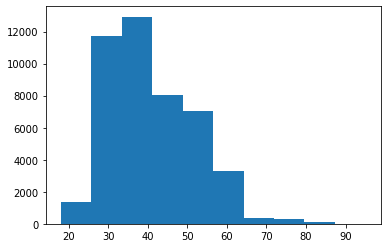

In [271]:
plt.hist((bank_with_dummies['age']),bins=10)
plt.show()

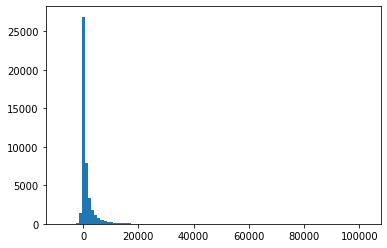

In [380]:
plt.hist((bank_with_dummies['balance']),bins=100)
plt.show()

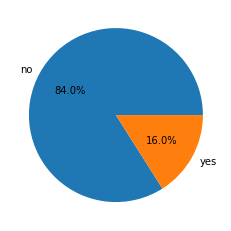

In [361]:
counts = [bank_with_dummies[bank_with_dummies["personal_loan"]==0].count()['personal_loan'], 
         bank_with_dummies[bank_with_dummies["personal_loan"]==1].count()['personal_loan']]
plt.pie(counts, labels=['no', 'yes'], autopct='%1.1f%%',)
plt.show()

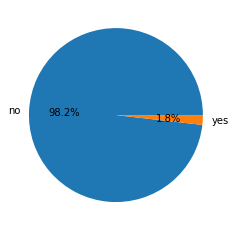

In [362]:
counts = [bank_with_dummies[bank_with_dummies["credit_default"]==0].count()['credit_default'], 
         bank_with_dummies[bank_with_dummies["credit_default"]==1].count()['credit_default']]
plt.pie(counts, labels=['no', 'yes'], autopct='%1.1f%%',)
plt.show()

## Classification

In [227]:
def classification(data):
    # Train-Test split: 20% test data
    bankcl = data
    data_drop_deposite = bankcl.drop('deposit', 1)
    label = bankcl.deposit
    data_train, data_test, label_train, label_test = train_test_split(data_drop_deposite, label, test_size = 0.2, random_state = 50)
    #Hyperparameters
    max_depth = 6
    criterions = ['gini', 'entropy']
    splitter = ['random', 'best']
    best_score = 0
    #Search for best combination
    for c in criterions:
        for s in splitter:
            i=2
            while i<max_depth:
                i+=1
                dt = tree.DecisionTreeClassifier(random_state=1, max_depth=i, criterion=c, splitter=s)
                dt.fit(data_train, label_train)
                dt_score_train = dt.score(data_train, label_train)
                #print("Training score: ",dt_score_train)
                dt_score_test = dt.score(data_test, label_test)
                #print("Testing score: ",dt_score_test)
                if dt_score_test > best_score:
                    best_score = dt_score_test
                    best_config = {'criterion': c, 'splitter': s, 'depth': i, 'test_score': dt_score_test, 'train_score': dt_score_train}
                    best_dt = dt
    print("Best score: ", best_score)
    print("Using config: ", best_config)

    return best_dt

In [248]:
def show_tree(dt, features, label='full'):   
    tree.export_graphviz(dt, out_file='tree.dot', class_names=['yes','no'], feature_names=features)
    filename = label + "tree.png"
    check_call(['dot','-Tpng','tree.dot','-o',filename])

    # Annotating chart with PIL
    img = Image.open(filename)
    draw = ImageDraw.Draw(img)
    img.save(filename)
    display(PImage(filename))

In [276]:
dt = classification(bank_with_dummies)

Best score:  0.8961627778392126
Using config:  {'criterion': 'gini', 'splitter': 'best', 'depth': 4, 'test_score': 0.8961627778392126, 'train_score': 0.8927781464277814}


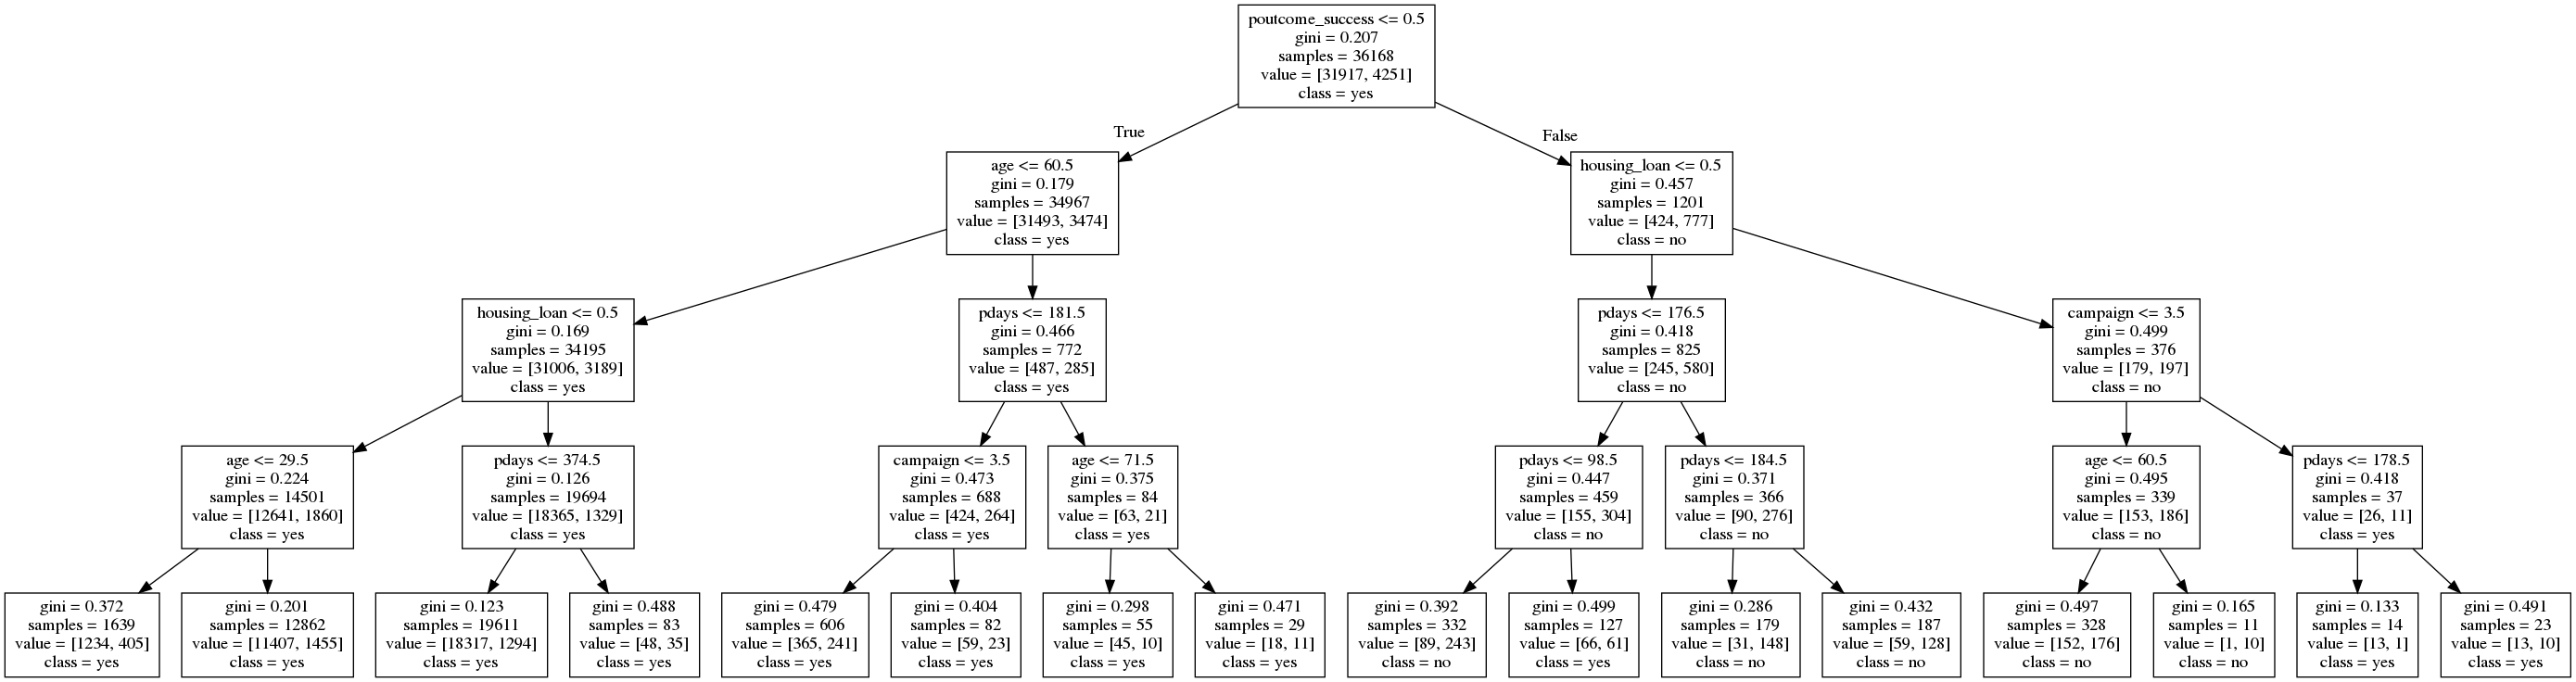

In [277]:
show_tree(dt, bank_with_dummies.drop('deposit', 1).columns.tolist())

## Questions

In [320]:
def check_children(index, is_leaves, children_right, children_left, values):
    if is_leaves[index]:
        if values[index][0][0]>values[index][0][1]:
            return "yes"
        else:
            return "no"
    else:
        result_right = check_children(children_right[index], is_leaves, children_right, children_left, values)
        result_left  = check_children(children_left[index], is_leaves, children_right, children_left, values)
        if result_right == result_left and result_right != "not-equal":
            return result_right
        else:
            return "not-equal"

In [345]:
def ask_questions(dt, is_leaves, features):
    n_nodes = dt.tree_.node_count
    children_left = dt.tree_.children_left
    children_right = dt.tree_.children_right
    feature = dt.tree_.feature
    threshold = dt.tree_.threshold
    values = dt.tree_.value
    binary_features = ['job', 'marital', 'education', 'poutcome', 'default', 'housing', 'loan', 'personal']
    i=0
    answers = {}
    while True:
        if is_leaves[i]:
            if values[i][0][0]>values[i][0][1]:
                result = "yes"
            else:
                result = "no"
            break
        else:
            result = check_children(i, is_leaves, children_right, children_left, values)
            if result != "not-equal":
                break
        if features[feature[i]] in answers:
            answer = answers[features[feature[i]]]
        else:
            feature_found = features[feature[i]]
            if isinstance(feature_found, str) and feature_found.split('_')[0] in binary_features:
                answer = input("Has %s %s?: " % (feature_found.split('_')[0], feature_found.split('_')[1]))
                if answer == 'yes':
                    answer = 1
                else:
                    answer = 0
            else:
                answer = input("What is the value for %s: " % (feature_found))
            answers[features[feature[i]]] = answer
        #print(answer)
        if float(answer) <= float(threshold[i]):
            i=children_left[i]
        else:
            i=children_right[i]

    print("Result is: %s" % result)

In [302]:
def get_leaves(dt):
    n_nodes = dt.tree_.node_count
    children_left = dt.tree_.children_left
    children_right = dt.tree_.children_right
    
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True
    return is_leaves

In [299]:
is_leaves = get_leaves(dt)

In [300]:
ask_questions(dt, is_leaves, bank_with_dummies.drop('deposit', 1).columns.tolist())

Has poutcome success?: yes
Has housing loan?: yes
What is the value for campaign: 9
Result is: yes


### Exclude outliers

In [363]:
data_outliers = bank_with_dummies

In [365]:
data_outliers.shape

(45211, 31)

In [367]:
data_outliers.describe()

,age,balance,campaign,pdays,previous,credit_default,housing_loan,personal_loan,deposit,job_admin.,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,...,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,2.763841,40.197828,0.580323,0.018027,0.555838,0.160226,0.116985,0.114375,...,0.115171,0.601933,0.282896,0.151534,0.513194,0.294198,0.041074,0.108403,0.858176,0.033421
std,10.618762,3044.765829,3.098021,100.128746,2.303441,0.133049,0.496878,0.366820,0.321406,0.318269,...,0.319232,0.489505,0.450411,0.358572,0.499831,0.455687,0.198464,0.310892,0.348873,0.179735
min,18.000000,-8019.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,72.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,39.000000,448.000000,2.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,48.000000,1428.000000,3.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,95.000000,102127.000000,63.000000,871.000000,275.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [418]:
np.mean(stats.zscore(data_outliers), axis=0)[5]

-3.771875352954459e-17

In [426]:
without = data_outliers[(np.abs(stats.zscore(data_outliers)) < 3).all(axis=1)]
without2 = data_outliers[(np.abs(stats.zscore(data_outliers)) < 2).all(axis=1)]

In [425]:
without.describe()

,age,balance,campaign,pdays,previous,credit_default,housing_loan,personal_loan,deposit,job_admin.,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success
count,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.0,7291.000000,7291.0,7291.0,7291.0,...,7291.0,7291.000000,7291.000000,7291.0,7291.00000,7291.00000,7291.0,7291.0,7291.0,7291.0
mean,38.775339,1038.002057,2.441915,1.446989,0.047181,0.0,0.599232,0.0,0.0,0.0,...,0.0,0.673844,0.326156,0.0,0.46962,0.53038,0.0,0.0,1.0,0.0
std,8.746451,1475.937743,1.659993,19.456865,0.388054,0.0,0.490088,0.0,0.0,0.0,...,0.0,0.468837,0.468837,0.0,0.49911,0.49911,0.0,0.0,0.0,0.0
min,21.000000,-1884.000000,1.000000,-1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.00000,0.00000,0.0,0.0,1.0,0.0
25%,32.000000,76.500000,1.000000,-1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.00000,0.00000,0.0,0.0,1.0,0.0
50%,37.000000,475.000000,2.000000,-1.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,...,0.0,1.000000,0.000000,0.0,0.00000,1.00000,0.0,0.0,1.0,0.0
75%,45.000000,1388.000000,3.000000,-1.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,...,0.0,1.000000,1.000000,0.0,1.00000,1.00000,0.0,0.0,1.0,0.0
max,62.000000,7449.000000,8.000000,239.000000,5.000000,0.0,1.000000,0.0,0.0,0.0,...,0.0,1.000000,1.000000,0.0,1.00000,1.00000,0.0,0.0,1.0,0.0


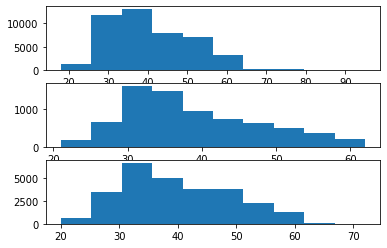

In [428]:
plt.subplot(3,1,1)
plt.hist((bank_with_dummies['age']),bins=10)
plt.subplot(3,1,2)
plt.hist((without2['age']),bins=10)
plt.subplot(3,1,3)
plt.hist((without['age']),bins=10)
plt.show()

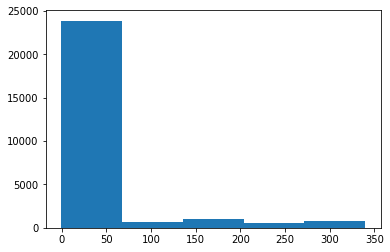

In [403]:
plt.subplot(2,1,1)
plt.hist((bank_with_dummies['pdays']),bins=10)
plt.subplot(2,1,2)
plt.hist((without['pdays']),bins=10)
plt.show()

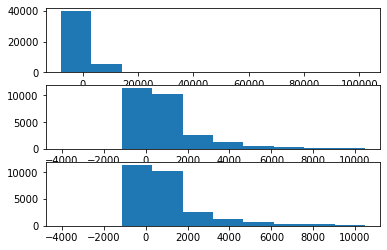

In [431]:
plt.subplot(3,1,1)
plt.hist((bank_with_dummies['balance']),bins=10)
plt.subplot(3,1,2)
plt.hist((without['balance']),bins=10)
plt.subplot(3,1,3)
plt.hist((without['balance']),bins=10)
plt.show()

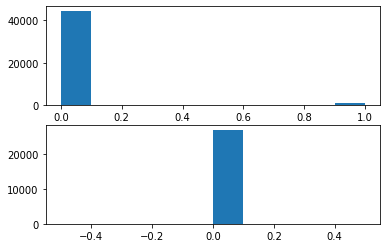

In [420]:
plt.subplot(2,1,1)
plt.hist((bank_with_dummies['credit_default']),bins=10)
plt.subplot(2,1,2)
plt.hist((without['credit_default']),bins=10)
plt.show()

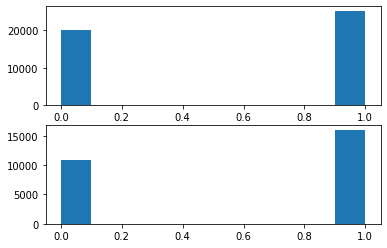

In [421]:
plt.subplot(2,1,1)
plt.hist((bank_with_dummies['housing_loan']),bins=10)
plt.subplot(2,1,2)
plt.hist((without['housing_loan']),bins=10)
plt.show()

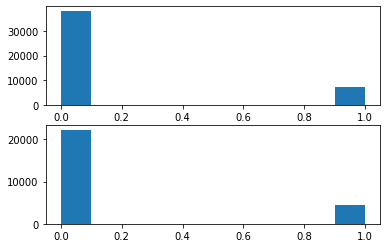

In [432]:
plt.subplot(2,1,1)
plt.hist((bank_with_dummies['personal_loan']),bins=10)
plt.subplot(2,1,2)
plt.hist((without['personal_loan']),bins=10)
plt.show()

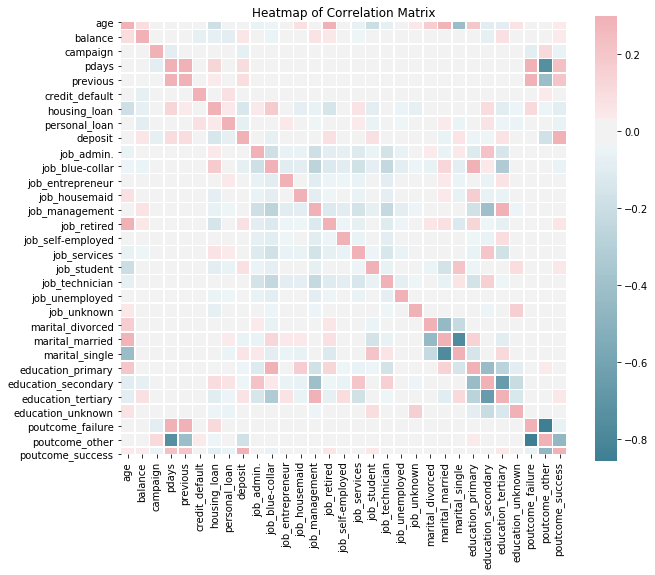

In [435]:
corr = bank_with_dummies.corr()
plt.figure(figsize = (10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Heatmap of Correlation Matrix')
plt.show()

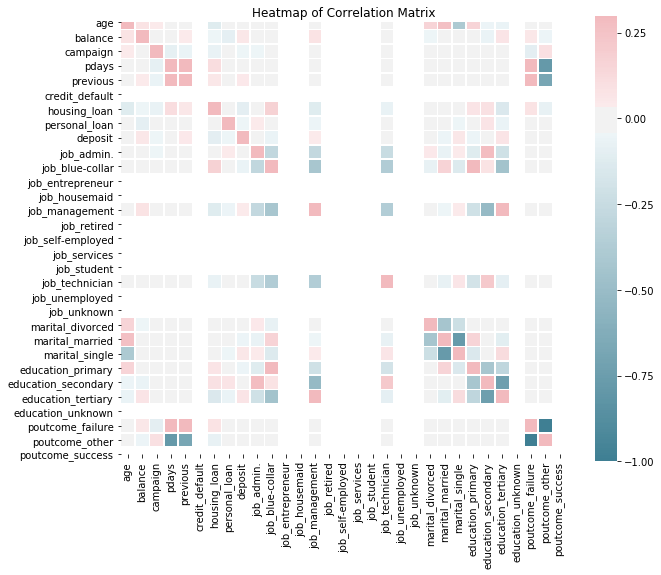

In [436]:
corr = without.corr()
plt.figure(figsize = (10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Heatmap of Correlation Matrix')
plt.show()

## Using additional Data

In [334]:
# Load data file
bank2=pd.read_csv('data/bank/bank-additional/bank-additional-full.csv', sep=';')
bank2.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [335]:
bank2.shape

(41188, 21)

## Summary of data:
### bank client data:
1 - age (numeric)
<br> 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
<br> 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
<br> 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
<br> 5 - default: has credit in default? (categorical: 'no','yes','unknown')
<br> 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
<br> 7 - loan: has personal loan? (categorical: 'no','yes','unknown')
### related with the last contact of the current campaign:
<br> 8 - contact: contact communication type (categorical: 'cellular','telephone')
<br> 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
<br> 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
<br> 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
### other attributes:
<br> 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
<br> 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
<br> 14 - previous: number of contacts performed before this campaign and for this client (numeric)
<br> 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
### social and economic context attributes
<br> 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
<br> 17 - cons.price.idx: consumer price index - monthly indicator (numeric)
<br> 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
<br> 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
<br> 20 - nr.employed: number of employees - quarterly indicator (numeric)

### Treat categorical data

In [340]:
# Make a copy for parsing
bank_data2 = bank2.copy()

# Combine 'unknown' and 'other'
bank_data2['poutcome'] = bank_data2['poutcome'].replace(['unknown'] , 'other')

# Drop 'contact', as every participant has been contacted. 
bank_data2.drop('contact', axis=1, inplace=True)

# values for "default" : yes/no
bank_data2["default"]
bank_data2['credit_default'] = bank_data2['default'].map( {'yes':1, 'no':0} )
bank_data2.drop('default', axis=1,inplace = True)

# values for "housing" : yes/no
bank_data2["housing_loan"]=bank_data2['housing'].map({'yes':1, 'no':0})
bank_data2.drop('housing', axis=1,inplace = True)

# values for "loan" : yes/no
bank_data2["personal_loan"] = bank_data2['loan'].map({'yes':1, 'no':0})
bank_data2.drop('loan', axis=1, inplace=True)

# Drop 'month' and 'day' as they don't have any intrinsic meaning
bank_data2.drop('month', axis=1, inplace=True)
bank_data2.drop('day_of_week', axis=1, inplace=True)

# Drop duration, since it is not known before the call and highly affects the outcome
bank_data2.drop('duration', axis=1, inplace=True)

# values for "y" : yes/no
bank_data2["deposit"] = bank_data2['y'].map({'yes':1, 'no':0})
bank_data2.drop('y', axis=1, inplace=True)

# Use pandas dummy to convert categorical data
bank_with_dummies2 = pd.get_dummies(data=bank_data2, columns = ['job', 'marital', 'education', 'poutcome'], prefix = ['job', 'marital', 'education', 'poutcome'])
bank_with_dummies2.fillna(0, inplace=True)
bank_with_dummies2.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,credit_default,...,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0,0,1,0,0,0,0,0,1,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,1,0,0,0,0,0,0,0,1,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0,0,1,0,0,0,0,0,1,0


In [341]:
dt2 = classification(bank_with_dummies2)

Best score:  0.896698227725176
Using config:  {'criterion': 'entropy', 'splitter': 'random', 'depth': 5, 'test_score': 0.896698227725176, 'train_score': 0.9011532625189681}


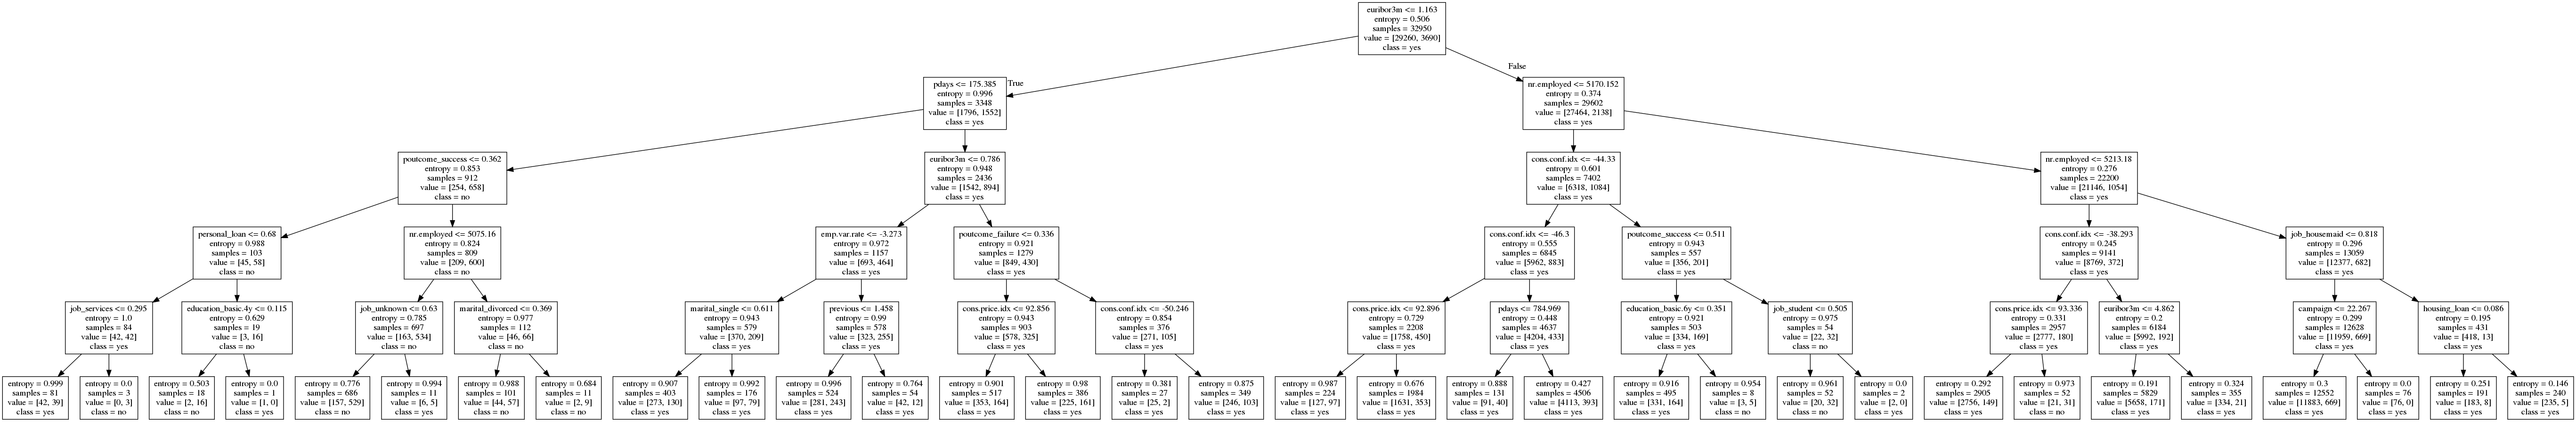

In [342]:
show_tree(dt2, bank_with_dummies2.drop('deposit', 1).columns.tolist(), label='additional')

In [343]:
is_leaves = get_leaves(dt2)

In [346]:
ask_questions(dt2, is_leaves,bank_with_dummies2.drop('deposit', 1).columns.tolist())

What is the value for euribor3m: 1
What is the value for pdays: 2
Has poutcome success?: no
Has personal loan?: yes
Has education basic.4y?: yes
Result is: yes
